In [124]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage.draw import polygon2mask
from scipy import ndimage
from PIL import Image
from preprocessing import biasCorrect
from skimage.color import label2rgb
from skimage.morphology import label
from IPython.display import display, clear_output

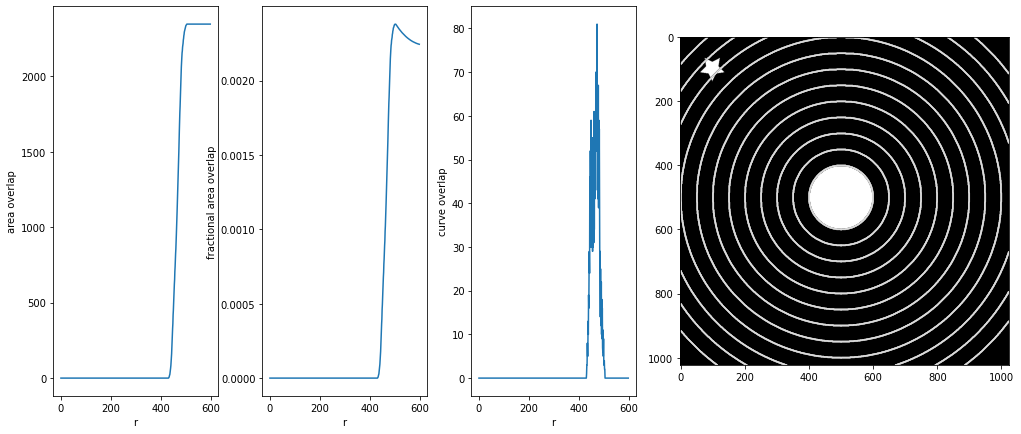

In [125]:
t = np.linspace(0,2*np.pi,11)   

canvas = np.zeros((1024,1024))
a = 0.5
xs = np.array([np.cos(t[0:-2:2]), a*np.cos(t[1:-1:2])])
ys = np.array([np.sin(t[0:-2:2]), a*np.sin(t[1:-1:2])])
star = np.array([np.concatenate(xs.T), np.concatenate(ys.T)]).T

t = np.linspace(0,2*np.pi,1000)
circle = np.array([np.cos(t), np.sin(t)]).T

star_mask = polygon2mask((1024,1024), (star*40) + 100)
circle_mask = polygon2mask((1024,1024), (circle*100) + 500)
all_mask = star_mask + circle_mask

fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
fig.subplots_adjust(wspace=0.4)
plt.tight_layout()


ax[3].imshow(all_mask)


D = ndimage.distance_transform_edt(circle_mask==0)
r_max = 600
f = np.zeros(r_max)
g = np.zeros(r_max)
for i in range(0,r_max):
    K = D<=i
    f[i] = np.count_nonzero(K*star_mask)
    g[i] = np.count_nonzero(K)
    if (i%50==0):
        ax[3].contour(K)
        display(fig)
        clear_output(wait = True)
        

ax[0].plot(f)
ax[0].set_xlabel('r')
ax[0].set_ylabel('area overlap')

ax[1].plot(f/g)
ax[1].set_xlabel('r')
ax[1].set_ylabel('fractional area overlap')

ax[2].plot(f[1:]-f[:-1])
ax[2].set_xlabel('r')
ax[2].set_ylabel('curve overlap')

plt.show()

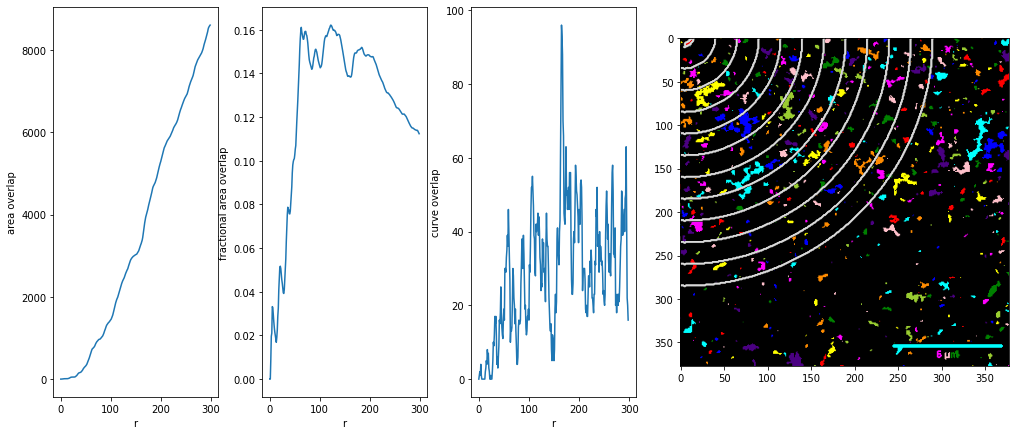

In [126]:
fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
fig.subplots_adjust(wspace=0.4)
plt.tight_layout()

path = 'images/1carr-96etoh-alexa-sted-decon.tif'
img = Image.open(path).convert("L")
image = np.array(img)
threshold_value = 110
bw = image > threshold_value
label_image = label(bw)
#label_image = biasCorrect()

ax[3].imshow(label2rgb(label_image, bg_label=0))

ref_cluster = label_image == 1
rem_clusters = np.logical_and((label_image != 1), (label_image != 0))


D = ndimage.distance_transform_edt(ref_cluster==0)
r_max = 300
f = np.zeros(r_max)
g = np.zeros(r_max)
for i in range(0,r_max):
    K = D<=i
    f[i] = np.count_nonzero(K*rem_clusters)
    g[i] = np.count_nonzero(K)
    if (i%25==0):
        ax[3].contour(K)
        display(fig)
        clear_output(wait = True)
        

ax[0].plot(f)
ax[0].set_xlabel('r')
ax[0].set_ylabel('area overlap')

ax[1].plot(f/g)
ax[1].set_xlabel('r')
ax[1].set_ylabel('fractional area overlap')

ax[2].plot(f[1:]-f[:-1])
ax[2].set_xlabel('r')
ax[2].set_ylabel('curve overlap')

plt.show()

/Users/marchioro/Desktop/Bachelor Github/preprocessing.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff, residuals, rank, singularValues = np.linalg.lstsq(VanderMondeMsk, ValsMsk)


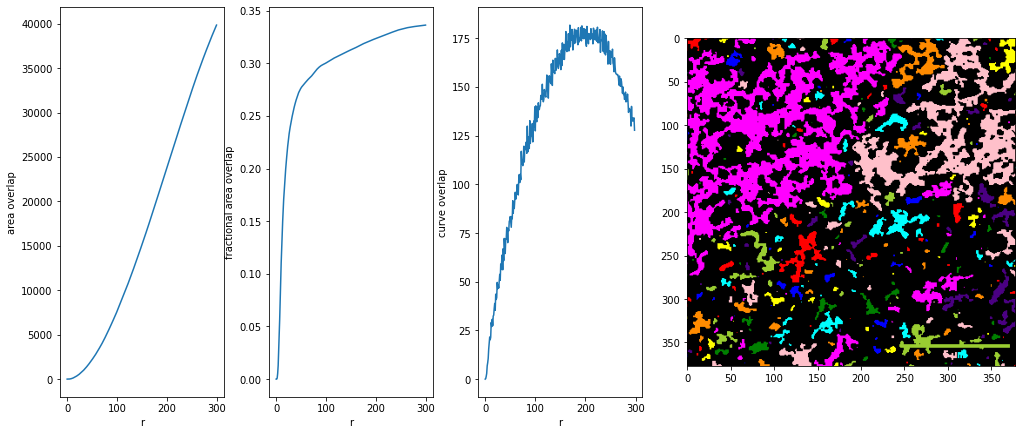

In [127]:
label_image = biasCorrect() #threshold=0.4)

canvas = np.zeros((378,378))

fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
fig.subplots_adjust(wspace=0.4)
plt.tight_layout()
ax[3].imshow(label2rgb(label_image, bg_label=0))


r_max = 300
F = np.zeros(r_max)
G = np.zeros(r_max)
for cluster in range (1, label_image.max()+1):
    ref_cluster = label_image == cluster
    rem_clusters = np.logical_and((label_image != cluster), (label_image != 0))


    D = ndimage.distance_transform_edt(ref_cluster==0)
    f = np.zeros(r_max)
    g = np.zeros(r_max)
    for i in range(0,r_max):
        K = D<=i
        f[i] = np.count_nonzero(K*rem_clusters)
        g[i] = np.count_nonzero(K)
    F += f
    G += g

F = F / label_image.max()
G = G / label_image.max()

ax[0].plot(F)
ax[0].set_xlabel('r')
ax[0].set_ylabel('area overlap')

ax[1].plot(F/G)
ax[1].set_xlabel('r')
ax[1].set_ylabel('fractional area overlap')

ax[2].plot(F[1:]-F[:-1])
ax[2].set_xlabel('r')
ax[2].set_ylabel('curve overlap')
plt.show()